### Test of generating alternating single qubit and two qubit layers

In [14]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_algorithms
!pip install qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.1 MB/s eta 0:00:00


In [85]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from layers import alternating_sq_2q_layers

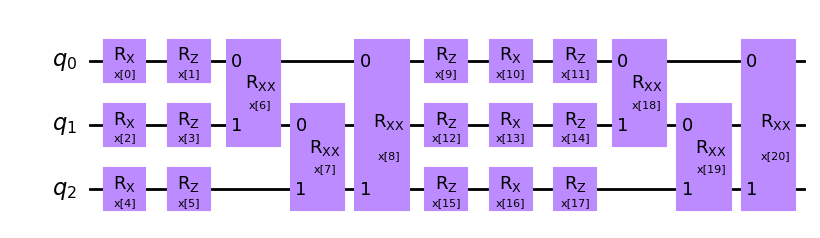

In [97]:
connectivity = [[0,1], [1,2], [0,2]]
circ = alternating_sq_2q_layers(3,2,'RXX', connectivity)
# circ.decompose().draw('mpl')
circ.draw('mpl')

In [99]:
# qasm convert
print(qiskit.qasm2.dumps(circ.assign_parameters(np.ones(21))))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
rx(1.0) q[0];
rz(1.0) q[0];
rx(1.0) q[1];
rz(1.0) q[1];
rx(1.0) q[2];
rz(1.0) q[2];
rxx(1.0) q[0],q[1];
rxx(1.0) q[1],q[2];
rxx(1.0) q[0],q[2];
rz(1.0) q[0];
rx(1.0) q[0];
rz(1.0) q[0];
rz(1.0) q[1];
rx(1.0) q[1];
rz(1.0) q[1];
rz(1.0) q[2];
rx(1.0) q[2];
rz(1.0) q[2];
rxx(1.0) q[0],q[1];
rxx(1.0) q[1],q[2];
rxx(1.0) q[0],q[2];


In [106]:
from qiskit_algorithms.optimizers import L_BFGS_B, COBYLA
from qiskit_aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi

intermediate_cost = []
intermediate_params = []

def cost(params, target):
    '''
    target: dict
            count_dictionary obtained from the probe circuit
    params:
    '''
    connectivity = [[0,1], [1,2], [0,2]]
    circ = alternating_sq_2q_layers(3,2,'RXX', connectivity, measurement=False).assign_parameters(params)
    result_dict = qi.Statevector.from_instruction(circ).probabilities_dict()
    cost = 0
    for (key1, value1), (key2, value2) in zip(target.items(), result_dict.items()):
        cost += (value1-value2)**2

    intermediate_cost.append(cost)
    intermediate_params.append(params)
    return cost

def callback_func(params, target):
    cost_value = cost(params, target)  # Calculate the cost at the current iteration
    intermediate_cost.append(cost_value)
    intermediate_params.append(params)

In [107]:
import torch
import torch.optim as optim
import qiskit.quantum_info as qi

params = np.ones(21)
circ = alternating_sq_2q_layers(3,2,'RXX', connectivity, measurement=False).assign_parameters(params)
target = qi.Statevector.from_instruction(circ).probabilities_dict()
target


{'000': 0.21420133513856127,
 '001': 0.08033388755180032,
 '010': 0.08033388755180029,
 '011': 0.05497454424205233,
 '100': 0.08033388755180035,
 '101': 0.05497454424205238,
 '110': 0.05497454424205229,
 '111': 0.37987336947988226}

In [102]:
target = {'000': 0.47, '111': 0.53}
target

{'000': 0.47, '111': 0.53}

In [109]:
from scipy.optimize import minimize
parameters = [np.random.random() for _ in range(21)]
out = minimize(cost, x0=parameters, args = target ,method="L-BFGS-B", options={'maxiter':100})
cost(out.jac,target)

0.7902105205305846

In [110]:
out.jac

array([ 1.67938850e-06,  1.19542703e-06, -2.45110174e-06, -7.17363773e-07,
        1.38175004e-06, -1.28975719e-06,  4.92425952e-06,  1.37882355e-06,
        2.02234335e-06, -1.52691216e-07, -1.96186387e-07,  9.06356759e-07,
       -1.75286749e-06,  2.91015597e-06, -1.96479843e-06,  1.18817507e-07,
        1.40131934e-06,  3.91524241e-07, -6.47034042e-07,  2.50266972e-06,
       -3.03647031e-06])

In [111]:
cost(intermediate_params[np.argmin(intermediate_cost)],target)

2.345872288659441e-10

In [113]:
check = alternating_sq_2q_layers(3,2,'RXX', connectivity, measurement=False).assign_parameters(intermediate_params[np.argmin(intermediate_cost)])
check_result = qi.Statevector.from_instruction(check).probabilities_dict()
check_result

{'000': 0.2142021881550795,
 '001': 0.0803362546904668,
 '010': 0.08032555994565764,
 '011': 0.054966942218943014,
 '100': 0.0803399300544422,
 '101': 0.05497159615903314,
 '110': 0.054981552768951246,
 '111': 0.3798759760074265}

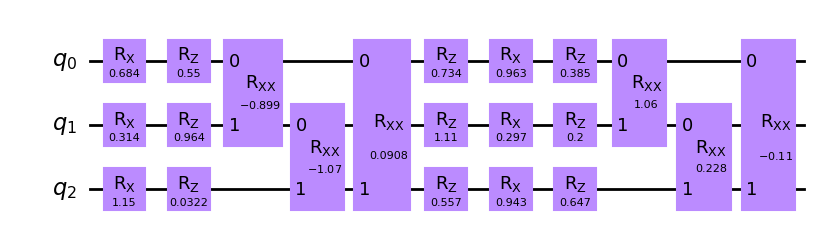

In [114]:
check.draw('mpl')

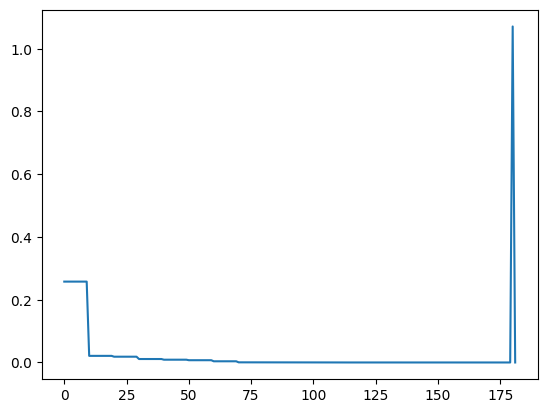

In [42]:
import matplotlib.pyplot as plt
plt.plot(intermediate_cost)